### Colin Alberts

## 0: Importing Packages and Defining Variables

### 0.0: Importing Packages

In [167]:
import numpy as np
import sympy as sp
import pandas as pd
import copy

import matplotlib.pyplot as plt

### 0.1: Defining Variables

In [168]:
T = 5               # expiry time
r = 0.2             # no-risk interest rate
sigma = 0.3         # volatility of underlying asset
delta = 0.1         # dividend rate
E = 100.            # exercise price
S_max = 2 * E       # upper bound of price of the stock (chosen somewhat arbitrarily, unlikely a security will double in price)
S_min = 0           # this is redundant
N = int(T * 100)    # time iterations
M = int(S_max * 4)  # space iterations, accurate to about 25 cents
option_type = "Call"

# time grid
t, ht = np.linspace(start = 0,
                    stop = T,
                    num = N + 1,
                    retstep = True)

# spatial grid (stock's price)
s, hs = np.linspace(0, 
                    S_max, 
                    M + 1, 
                    retstep = True)

def initial_condition(x, option):
    x_copy = x
        
    if option == 'Call':
        x_copy[:, -1] = np.maximum(s - E, 0)
        x_copy[0, :] = 0
        x_copy[-1, :] = np.exp(-r * (T - t)) * (S_max - E)
    elif option == 'Put':
        x_copy[:, -1] = np.maximum(E - s, 0)
        x_copy[0, :] = np.exp(-r * (T - t)) * (E - S_min)
        x_copy[-1, :] = 0

    return x_copy

# solution grid
solution = np.zeros(shape = (M + 1, N + 1))
solution = initial_condition(solution, option_type)


### 0.2: Optimization Functions

In [169]:
# Thomas Algorithm, is only stable when matrix is diagonally dominant or SPD.
def thomas(a, b, c, d):
    dim = len(d)  # nr of equations to be solved
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for i in range(1, dim):
        w = ac[i - 1] / bc[i - 1]
        bc[i] = bc[i] - w * cc[i - 1]
        dc[i] = dc[i] - w * dc[i - 1]
    x = bc
    x[-1] = dc[-1] / bc[-1]

    for j in range(dim - 2, -1, -1):
        x[j] = (dc[j] - cc[j] * x[j + 1]) / bc[j]
    return x

# 1: Crank-Nicolson Implementation

## 1.1: Constructing Matrices

The [link](https://github.com/katpirat/Finite-difference-for-PDEs/blob/main/FD_for_BlackScholes_pricing.py) to the source that I ~~stole~~ took inspiration from.

In [170]:
def crank():
    crank_solution = copy.deepcopy(solution)
    
    u_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) - (r - delta) * s / (4 * hs)
    v_vec = (sigma ** 2 * s ** 2) / (2 * hs ** 2) + r / 2
    w_vec = (sigma ** 2 * s ** 2) / (4 * hs ** 2) + (r - delta) * s / (4 * hs)
    
    P_mat = -np.diag(u_vec[2:-1] * ht, -1) + np.diag(v_vec[1:-1] * ht) - np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
    
    offset_1 = np.zeros(M - 1)
    offset_2 = np.zeros(M - 1)
    
    for i in range(N, 0, -1):
        offset_1[0] = crank_solution[0, i] * u_vec[1] * -2
        offset_1[-1] = crank_solution[-1, i] * w_vec[-1] * -2

        offset_2[0] = crank_solution[0, i - 1] * u_vec[1] * -2
        offset_2[-1] = crank_solution[-1, i - 1] * w_vec[-1] * -2
        
        Q_mat = np.diag(u_vec[2:-1] * ht, -1) - np.diag(v_vec[1:-1] * ht) + np.diag(w_vec[1:-2] * ht, 1) + np.identity(M - 1)
        
        RHS = np.dot(Q_mat, crank_solution[1:-1, i]) - ht / 2 * (offset_1 + offset_2)
        
        crank_solution[1:-1, i - 1] = thomas(np.diag(P_mat, -1),
                                             np.diag(P_mat),
                                             np.diag(P_mat, 1),
                                             RHS)
        
    df = pd.DataFrame(crank_solution, columns = [str(ht * i) for i in range(N + 1)])

    return df



## 1.2: Plot Function

In [171]:
def surface_plot(solution):
    fig = plt.figure(figsize=(40, 6))
    ax2 = fig.add_subplot(111, projection="3d")
    
    X, Y = np.meshgrid(t, s)
    
    ax2.plot_surface(Y, X, solution, cmap = "plasma")
    ax2.set_title("Price Surface"); ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
    
    if option_type == 'Call':
        ax2.view_init(30, 140)  
    else:
        ax2.view_init(30, 30)
        
    plt.show()

## 1.3: Solve and Plot

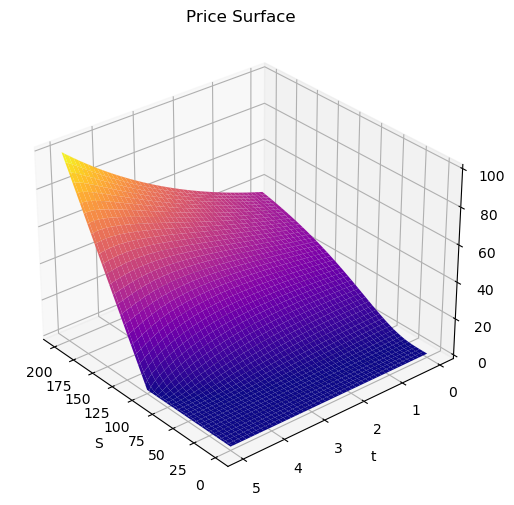

In [172]:
surface_plot(crank())